<a href="https://colab.research.google.com/github/RomanZavar/Data_Science/blob/main/H_W_5_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Задание
Вам предстоит решить типичную для продуктовой аналитики задачу прогноза *LTV пользователя. Для этого необходимо:
* 1) провести исследовательский анализ данных,
* 2) визуализировать результаты и сделать из них выводы,
* 3) провести предобработку признаков (возможно создать новые),
* 4) обучить модели, и подобрать для каждой из них оптимальные гиперпараметры,
* 5) оценить работу моделей и сравнить их между собой, выбрать итоговую и объяснить свой выбор,
* 6) проинтерпретировать получившиеся результаты (что и как влияет на LTV пользователя).
Данные
В файле LTV.csv представлены данные о пользователях с автомобильной страховкой, собранных системой аналитики компании IBM. https://www.ibm.com/communities/analytics/watson-analytics-blog/marketing-customer-value-analysis/
Описание данных:
Customer - идентификатор пользователя\
State - штат\
Customer Lifetime Value - LTV пользователя\
Response - взаимодействие с рекламой\
Coverage - тип страхового покрытия\
Education - образование\
Effective to date - срок действия страховки\
EmploymentStatus - трудоустройство\
Gender - пол\
Income - доход\
Location code - тип местности в которой проживает пользователь\
Marital Status - семейное положение\
Monthly Premium Auto - ежемесячный взнос за авто\
Months Since Last Claim - месяцев с последнего требования по выплате компенсации\
Months Since Policy Inception - месяцев с открытия страховки\
Number of Open Complaints - количество незакрытых жалоб\
Number of Policies - количество полисов\
Policy Type - тип страховки\
Policy - страховка\
Renew Offer Type - обновленный тип предложения\
Sales Channel - канал продаж\
Total Claim Amount - сумма выплаченных компенсаций\
Vehicle Class - класс автомобиля\
Vehicle Size - размер автомобиля



*LTV — это прибыль компании, которую она получила от одного человека за всё время сотрудничества с ним. Отвечает на вопрос, сколько денег компании приносит заказчик.
Расшифровывается как lifetime value и в переводе означает «жизненный цикл клиента». Иногда метрику называют пожизненной ценностью клиента — ПЦК, customer lifetime value, CLV или CLTV. Все эти обозначения подразумевают одно и то же.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings # перестает выкидывать ошибки(для более презентабельного вида бука)

warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

In [4]:
df = pd.read_csv('LTV.csv')
df.sample(10)

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
6191,EX80215,California,2822.731903,No,Extended,College,2/19/11,Unemployed,F,0,...,86,0,1,Personal Auto,Personal L1,Offer1,Web,138.947984,Four-Door Car,Large
6221,RU39880,California,11747.653730,No,Basic,Bachelor,1/10/11,Employed,F,58658,...,23,0,2,Personal Auto,Personal L3,Offer4,Call Center,355.200000,Two-Door Car,Medsize
1070,MY31220,California,8997.040244,No,Premium,College,1/15/11,Employed,F,54230,...,21,0,9,Personal Auto,Personal L2,Offer2,Agent,537.600000,Two-Door Car,Medsize
5542,FU65756,Arizona,8177.048957,No,Basic,College,2/12/11,Employed,F,54695,...,94,0,5,Personal Auto,Personal L3,Offer1,Branch,494.400000,SUV,Medsize
2356,DR84620,California,8071.334962,No,Basic,Bachelor,2/7/11,Employed,M,72149,...,43,0,6,Personal Auto,Personal L2,Offer2,Call Center,69.310166,SUV,Medsize
2938,UE67791,Arizona,5885.335302,No,Basic,College,1/9/11,Unemployed,M,0,...,20,3,2,Personal Auto,Personal L3,Offer1,Agent,482.400000,Two-Door Car,Medsize
4711,NM37561,California,7408.167551,No,Basic,High School or Below,1/11/11,Employed,M,62810,...,22,1,1,Corporate Auto,Corporate L2,Offer3,Web,32.874675,Luxury Car,Medsize
7275,ZI85739,California,15860.035910,No,Extended,Master,2/25/11,Unemployed,F,0,...,41,0,2,Personal Auto,Personal L1,Offer1,Branch,46.098963,SUV,Small
1270,AC75391,Arizona,5768.091295,No,Basic,College,1/1/11,Employed,F,35091,...,19,0,9,Corporate Auto,Corporate L1,Offer1,Branch,418.927204,Two-Door Car,Medsize
3320,AZ64856,California,5048.051359,No,Extended,High School or Below,2/17/11,Employed,F,34452,...,51,0,1,Personal Auto,Personal L1,Offer4,Agent,604.800000,SUV,Large


In [5]:
# проще выполнять встроенной функцией select.dtypes, в примере итерационный метод
num_cols = []
str_cols = []

cols_and_type = df.dtypes.to_dict()

for col in cols_and_type:
    if cols_and_type[col] in ('int64', 'float64'):
        num_cols.append(col)
    else:
        str_cols.append(col)

print(f'числовые значения = {num_cols}')


print(f'категориальные значения = {str_cols}')

числовые значения = ['Customer Lifetime Value', 'Income', 'Monthly Premium Auto', 'Months Since Last Claim', 'Months Since Policy Inception', 'Number of Open Complaints', 'Number of Policies', 'Total Claim Amount']
категориальные значения = ['Customer', 'State', 'Response', 'Coverage', 'Education', 'Effective To Date', 'EmploymentStatus', 'Gender', 'Location Code', 'Marital Status', 'Policy Type', 'Policy', 'Renew Offer Type', 'Sales Channel', 'Vehicle Class', 'Vehicle Size']


In [6]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

num_pipline = Pipeline(steps=[('scale', MinMaxScaler())])
str_pipline = Pipeline(steps=[('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [7]:
from sklearn.compose import ColumnTransformer

col_trans = ColumnTransformer(transformers=[('num_pipline', num_pipline, num_cols),
                                            ('str_pipline', str_pipline, str_cols)],
                                             remainder = 'drop',
                                             n_jobs = -1)

In [8]:
from sklearn import set_config

set_config(display='diagram')
display(col_trans)

ColumnTransformer(n_jobs=-1,
                  transformers=[('num_pipline',
                                 Pipeline(steps=[('scale', MinMaxScaler())]),
                                 ['Customer Lifetime Value', 'Income',
                                  'Monthly Premium Auto',
                                  'Months Since Last Claim',
                                  'Months Since Policy Inception',
                                  'Number of Open Complaints',
                                  'Number of Policies', 'Total Claim Amount']),
                                ('str_pipline',
                                 Pipeline(steps=[('one-hot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Customer', 'State', 'Response', 'Coverage',
                                  'Education', 'Effective To Date',
                                  'EmploymentStatus', 'Gender', 'Location Code',
                                  'Marital Status', 'Policy Type', 'Policy',
                                  'Renew Offer Type', 'Sales Channel',
                                  'Vehicle Class', 'Vehicle Size'])])

In [9]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
for col in str_cols:
    df[col] = le.fit_transform(df[col])



df.sample(10)

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
7823,8409,3,2317.282049,0,0,0,7,4,0,0,...,81,0,1,0,1,0,2,489.600000,5,1
103,1657,1,4330.386020,1,2,1,38,1,1,60475,...,18,0,1,1,5,1,1,513.600000,0,1
596,5094,3,2908.875917,0,0,1,21,1,0,35895,...,51,0,1,1,5,1,0,312.921256,0,1
6099,5654,2,2871.145075,0,0,1,20,1,1,94178,...,25,1,1,1,4,1,3,226.103360,0,1
8607,2723,1,5389.499465,1,1,1,28,1,1,66429,...,93,0,1,0,2,1,0,57.712985,4,1
1050,449,0,2600.272131,0,0,3,12,1,1,51978,...,81,0,1,0,2,1,0,144.782152,0,1
8177,605,1,4647.423581,0,1,0,33,1,1,28314,...,37,0,1,1,5,0,0,580.800000,3,1
2662,6369,1,8986.610653,0,2,3,18,1,1,66267,...,95,0,3,1,4,2,3,1093.708851,0,2
2864,1,2,2568.843396,0,0,0,20,2,0,11167,...,99,3,1,1,5,1,1,350.400000,5,1
4439,2372,1,11281.524510,0,1,3,37,1,0,86195,...,10,0,3,2,7,0,0,601.667902,3,1


In [10]:
from sklearn.model_selection import train_test_split

df = df[num_cols+str_cols]
train_df, test_df = train_test_split(df, train_size=0.2, random_state=42)

print("Тренировочной выборка:", train_df.shape)
print("Тестовая выборка:", test_df.shape)

Тренировочной выборка: (1826, 24)
Тестовая выборка: (7308, 24)


Выделим матрицу признаков и вектор с целевой переменной в тренировочной выборке

In [11]:
X = train_df.drop('Response', axis = 1) # в датасете х - храним все виды переменных(колонок) за исключением целевой '' axis = 1 строка 0 = столбец
y = train_df['Response'] # в датасете y - оставляем только целевую переменную (грубо говоря это вектор из нашей целевой переменной)

In [12]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1826 entries, 409 to 7270
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer Lifetime Value        1826 non-null   float64
 1   Income                         1826 non-null   int64  
 2   Monthly Premium Auto           1826 non-null   int64  
 3   Months Since Last Claim        1826 non-null   int64  
 4   Months Since Policy Inception  1826 non-null   int64  
 5   Number of Open Complaints      1826 non-null   int64  
 6   Number of Policies             1826 non-null   int64  
 7   Total Claim Amount             1826 non-null   float64
 8   Customer                       1826 non-null   int64  
 9   State                          1826 non-null   int64  
 10  Response                       1826 non-null   int64  
 11  Coverage                       1826 non-null   int64  
 12  Education                      1826 non-null   int6

## посмотрим на распределение признаков


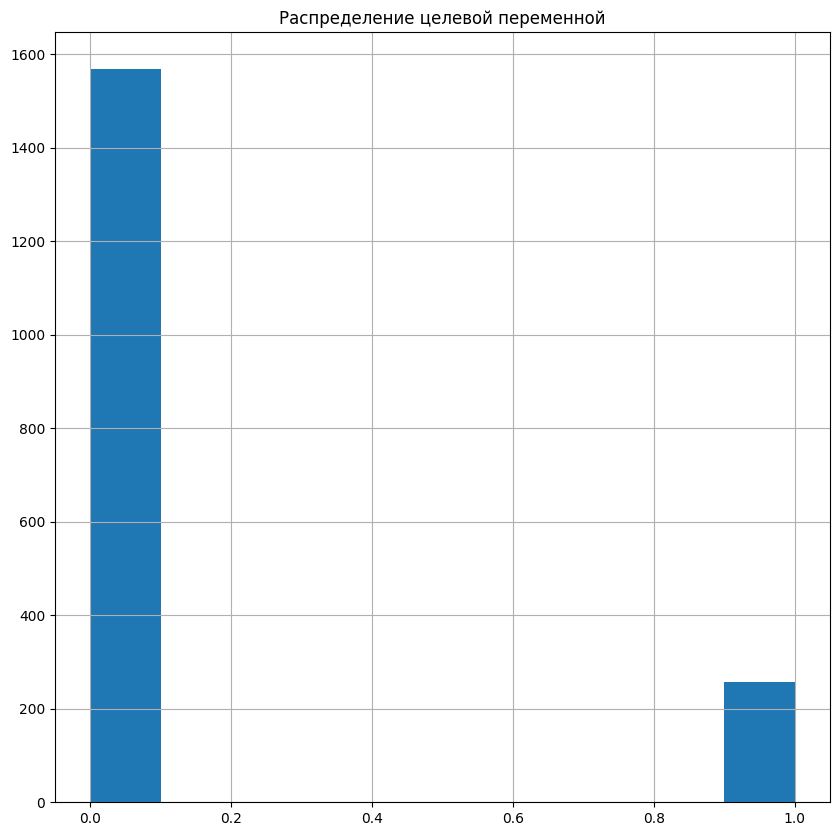

In [14]:
plt.figure(figsize = (10, 10))
plt.title('Распределение целевой переменной')
train_df['Response'].hist()

plt.show()

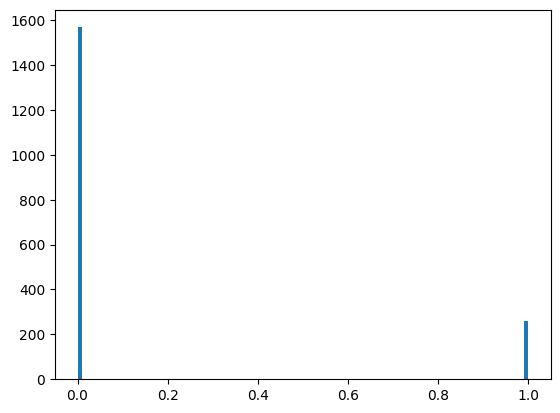

In [15]:
plt.hist(train_df['Response'], bins = 100)
plt.show();

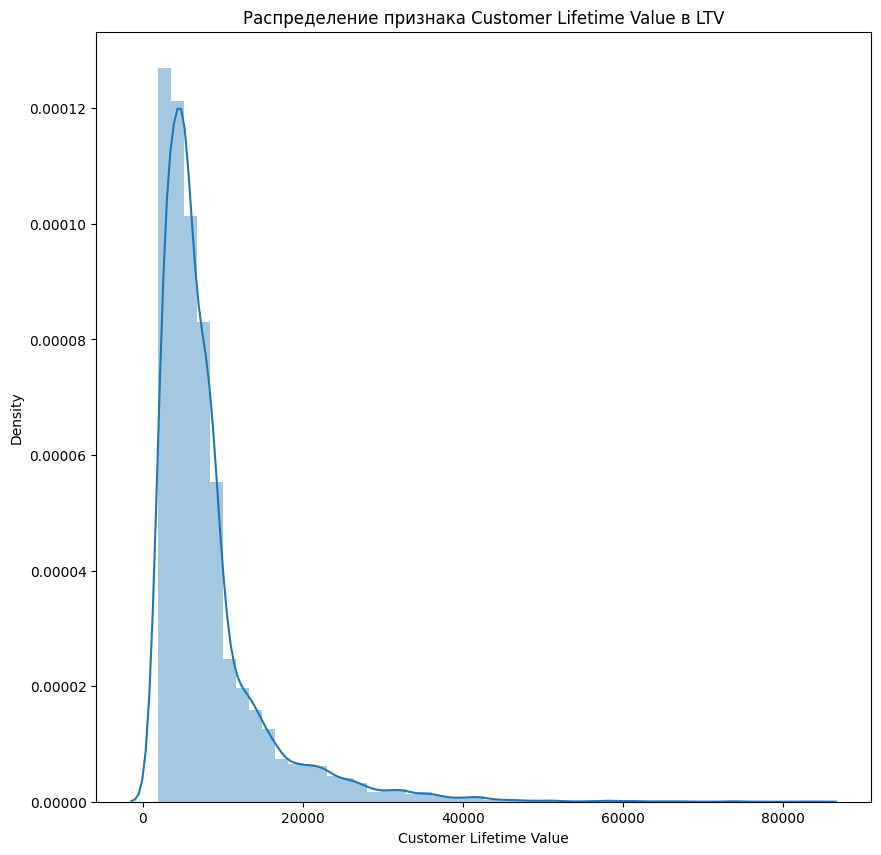

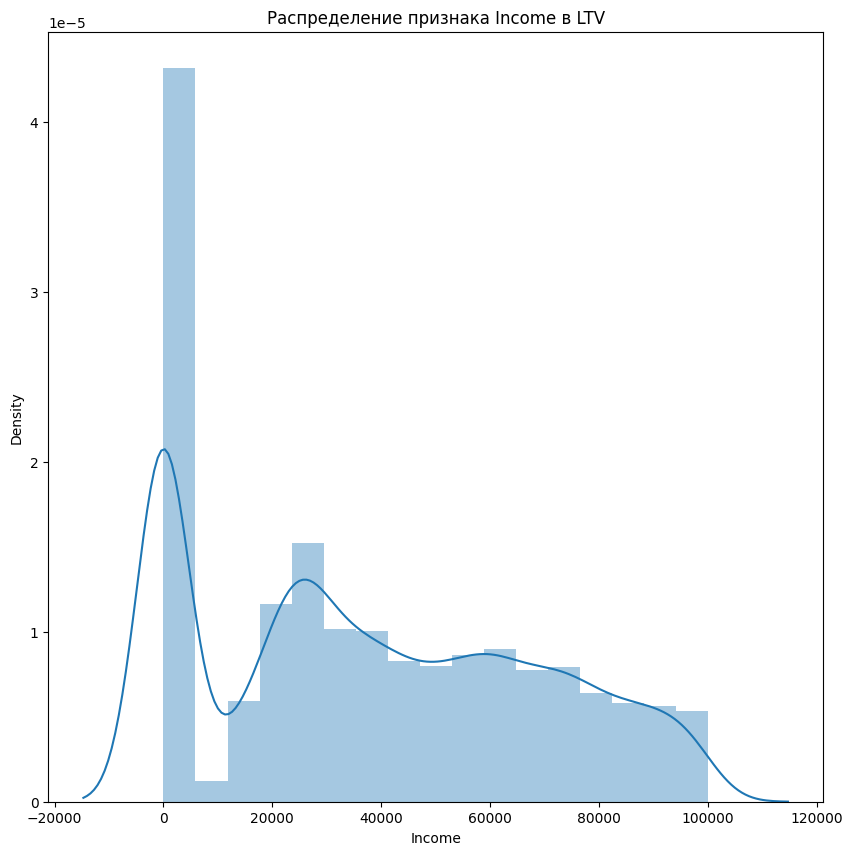

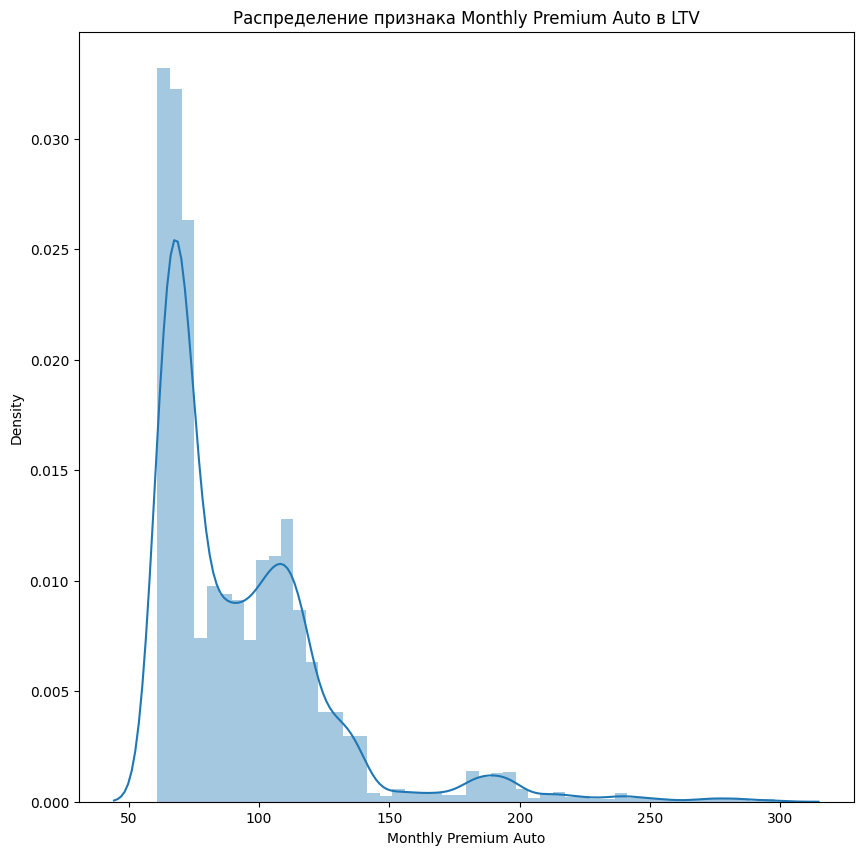

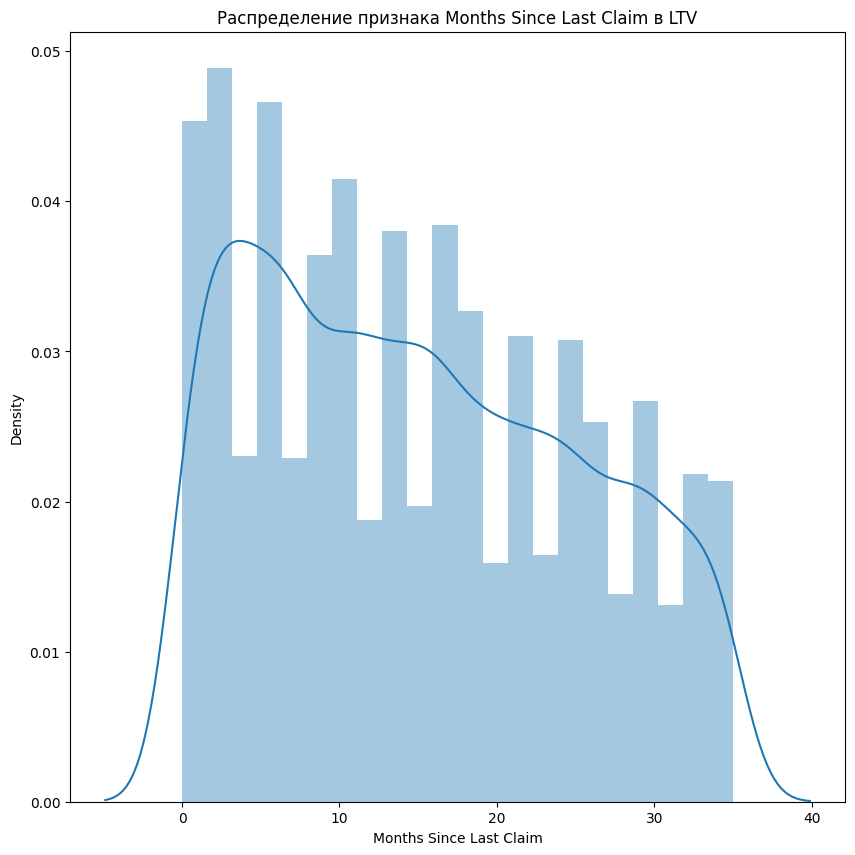

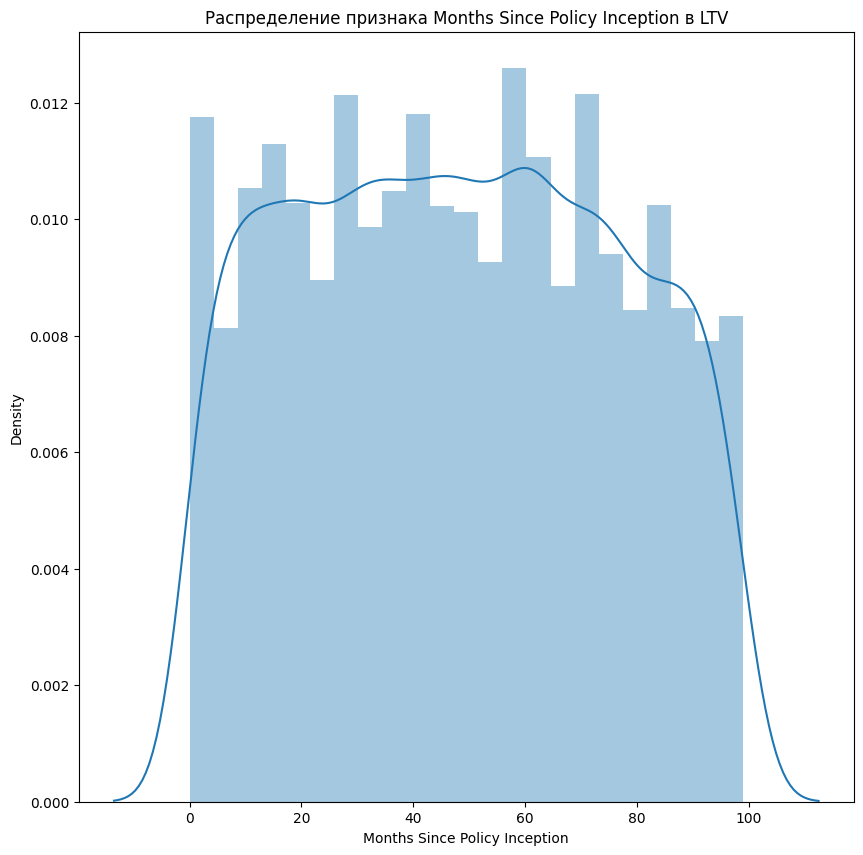

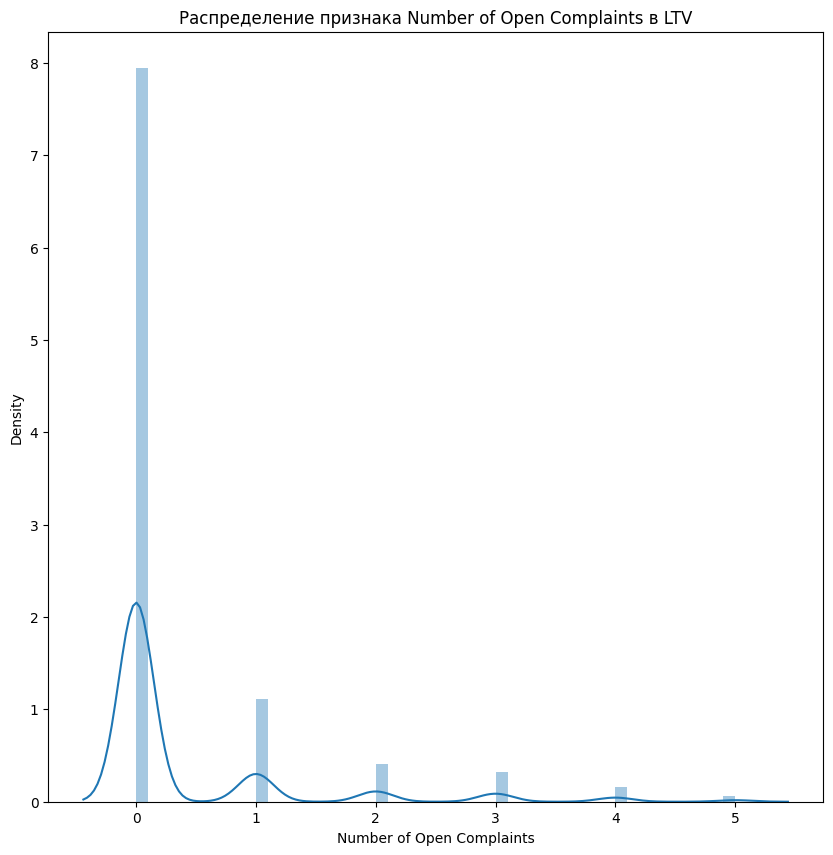

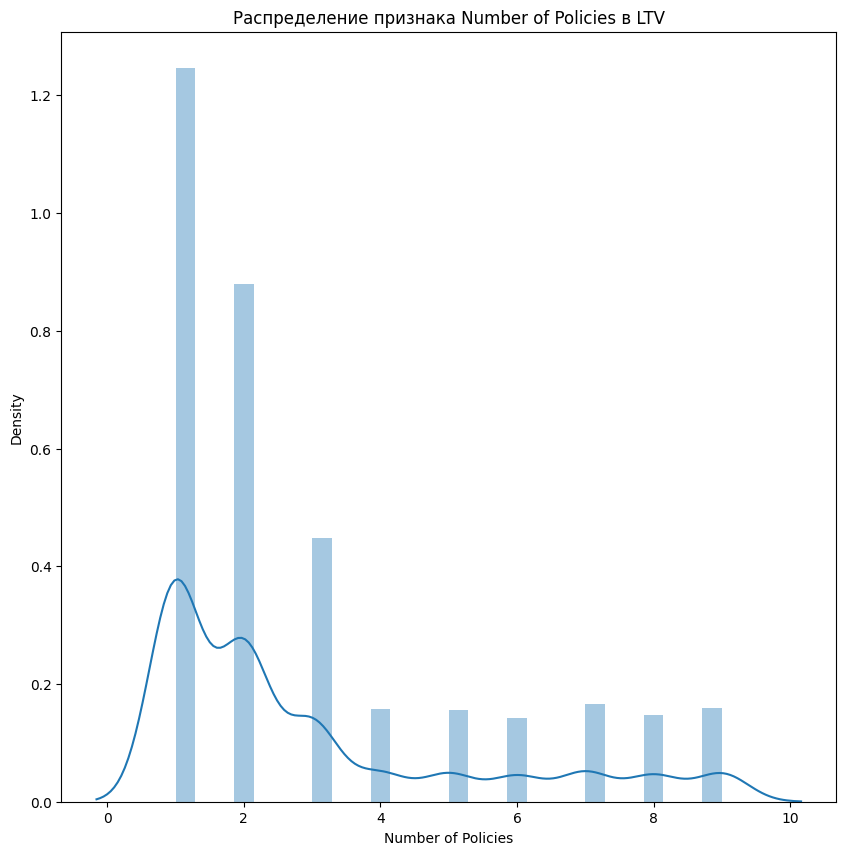

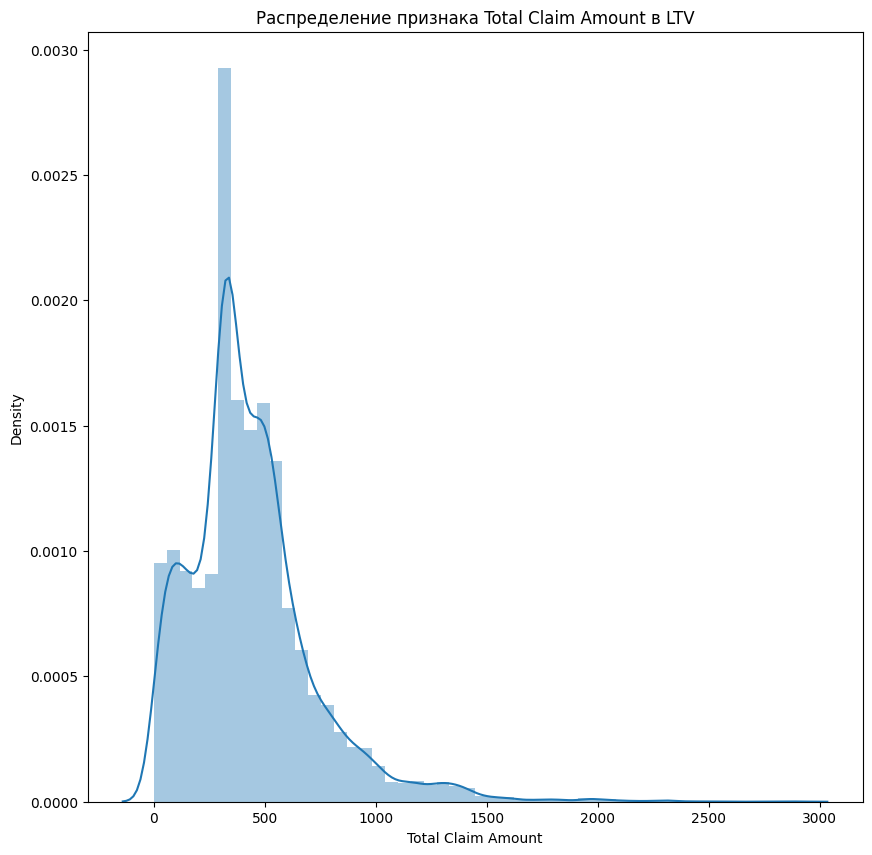

In [57]:
for col in num_cols:
    plt.figure(figsize = (10, 10))
    plt.title(f'Распределение признака {col} в LTV')
    sns.distplot(df[col])

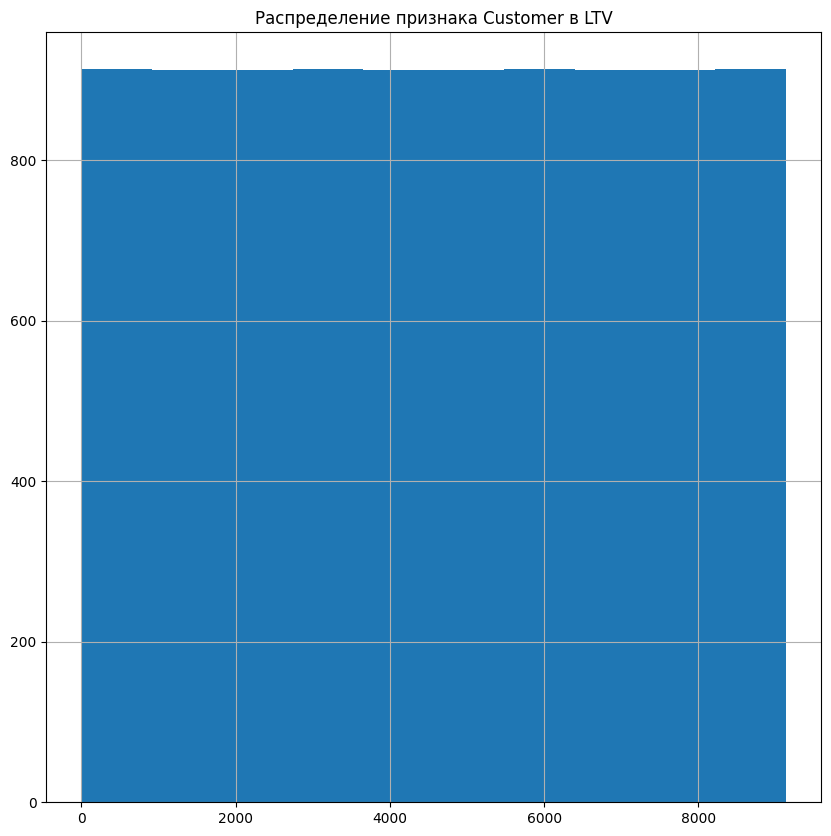

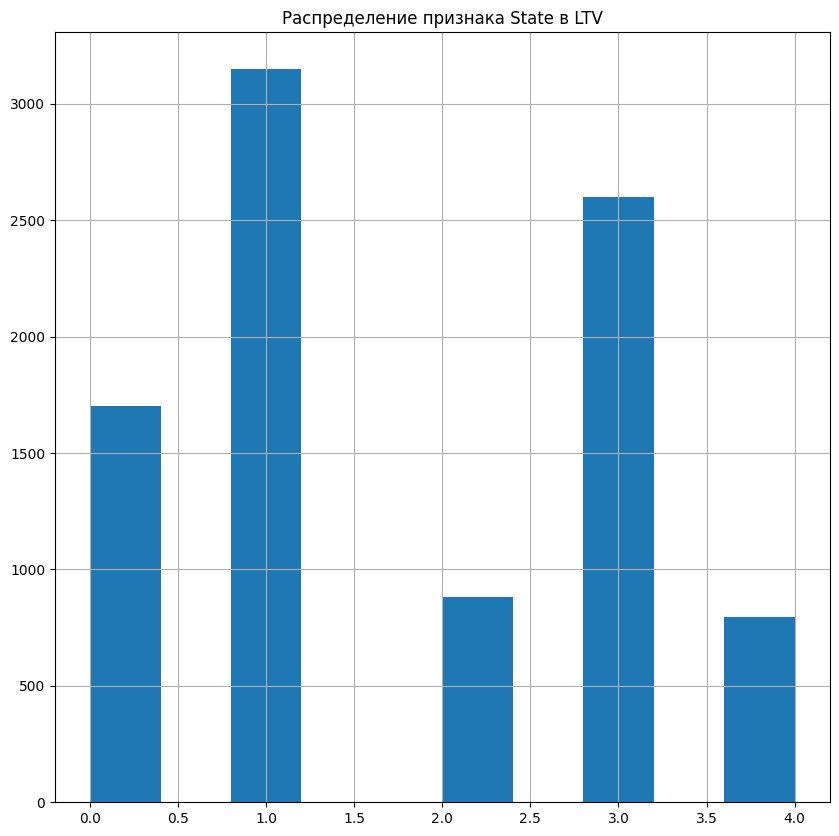

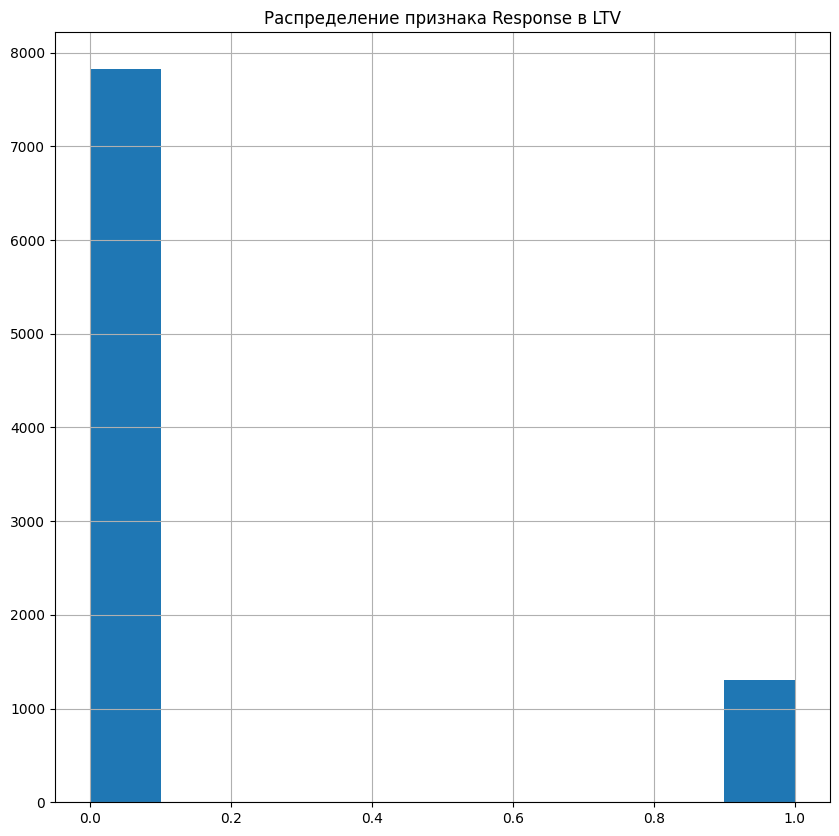

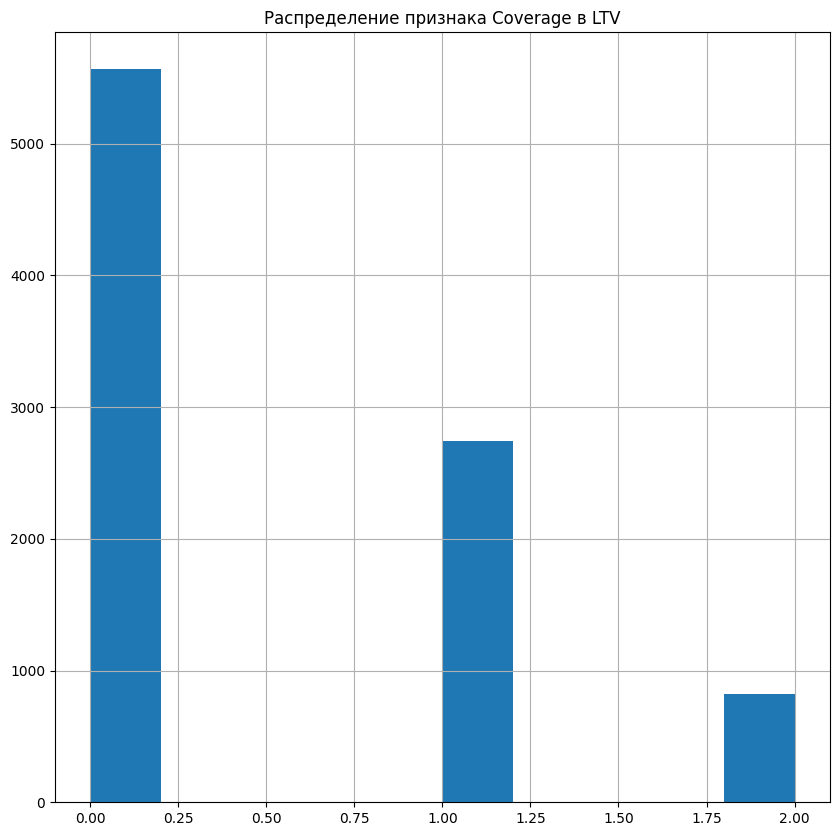

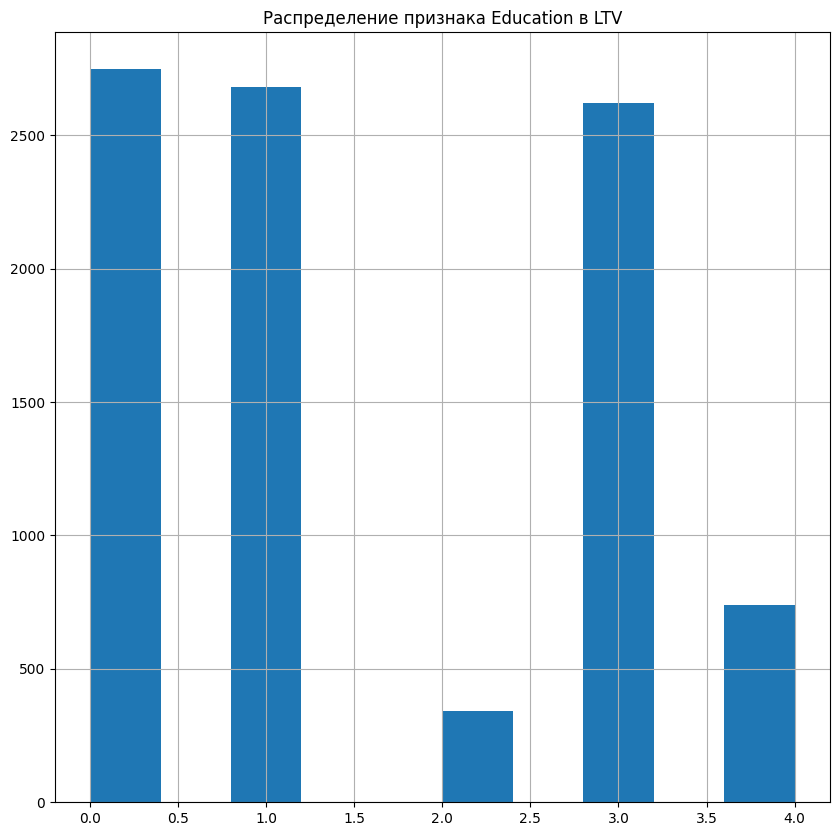

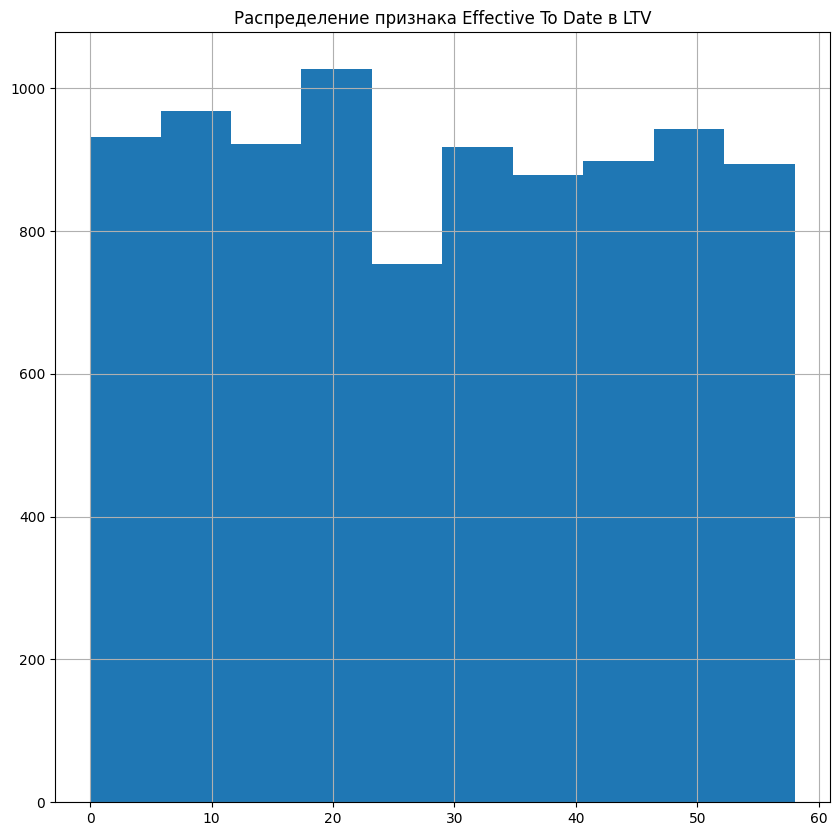

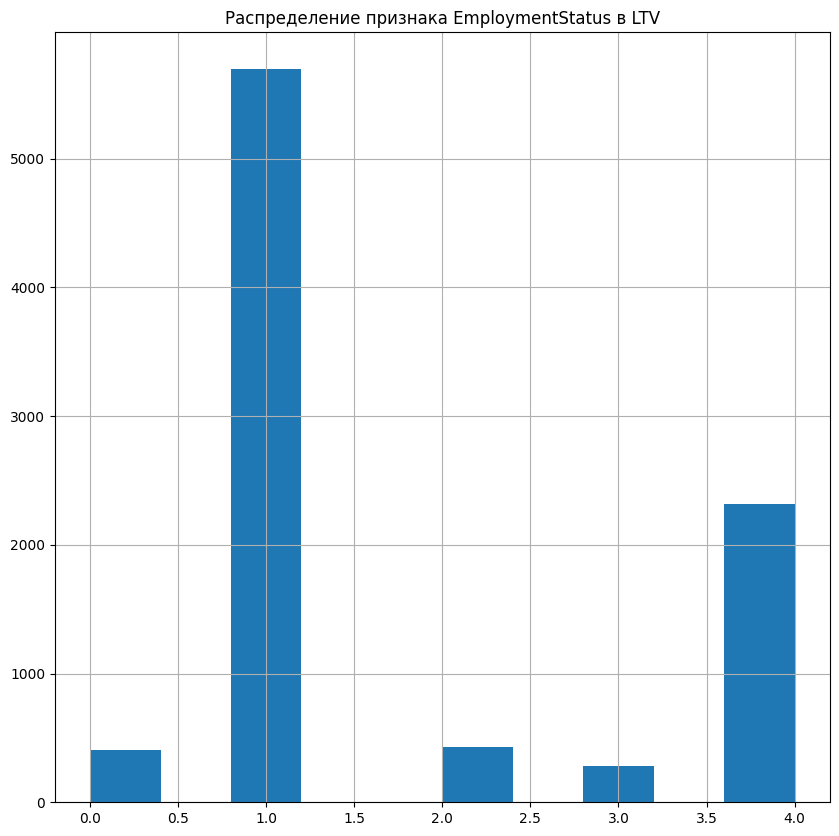

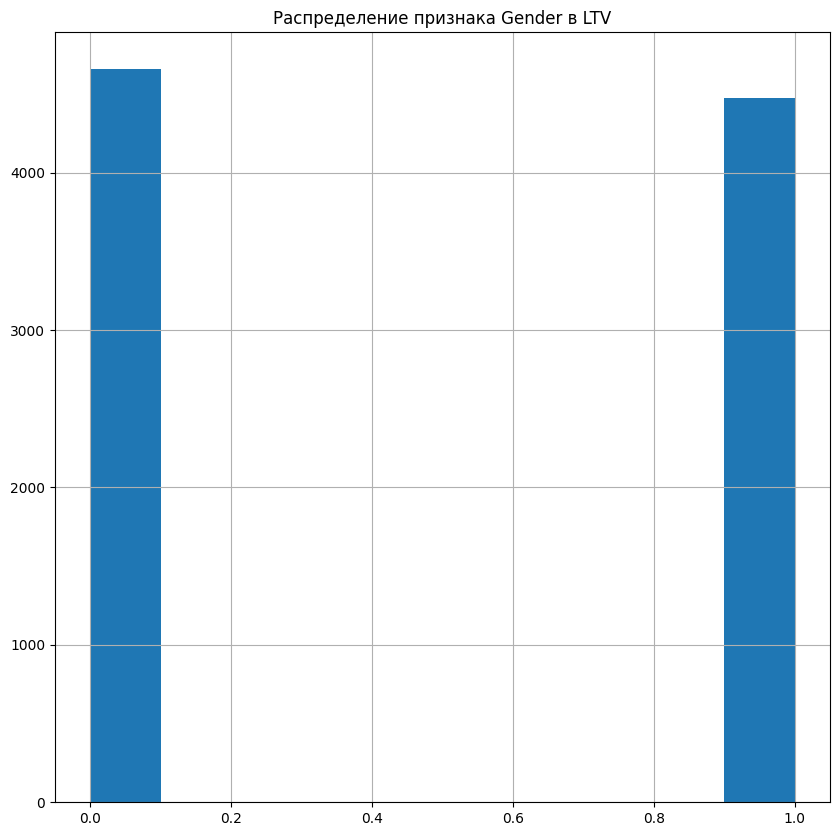

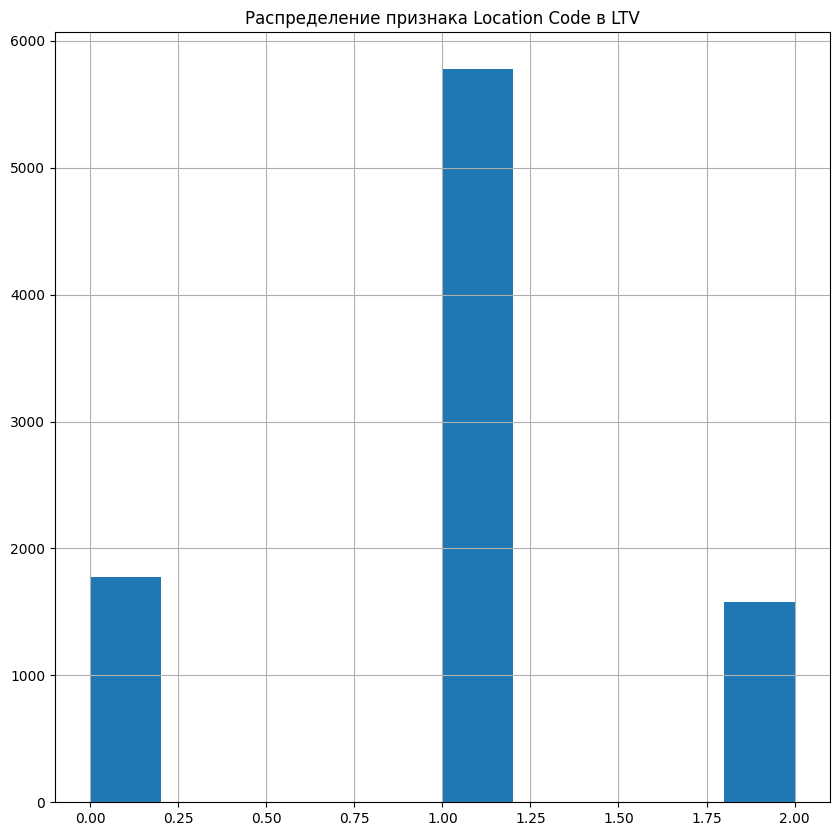

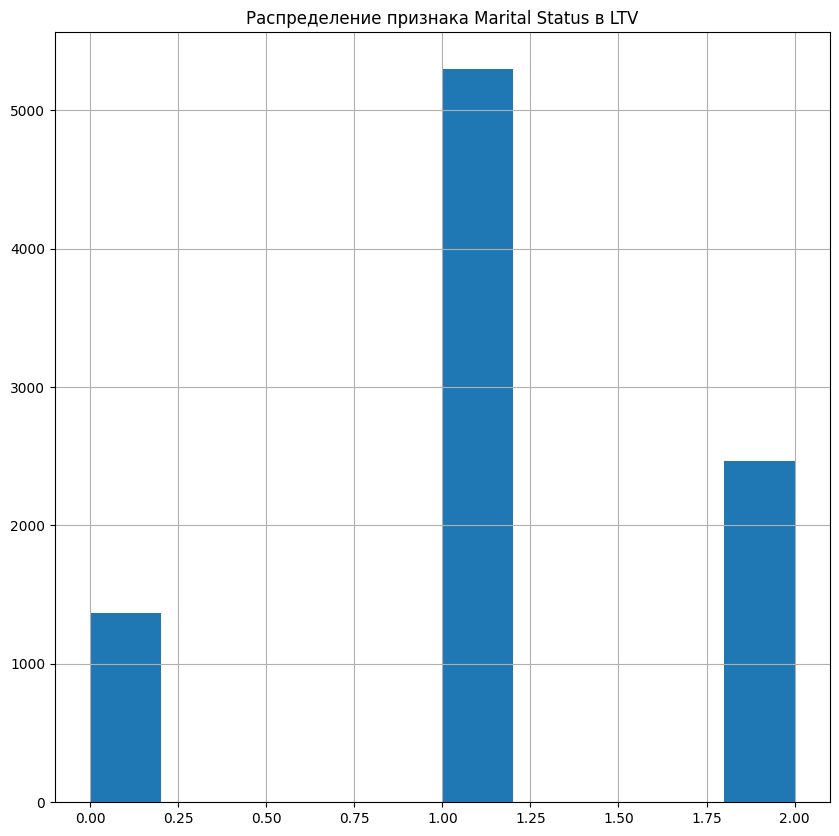

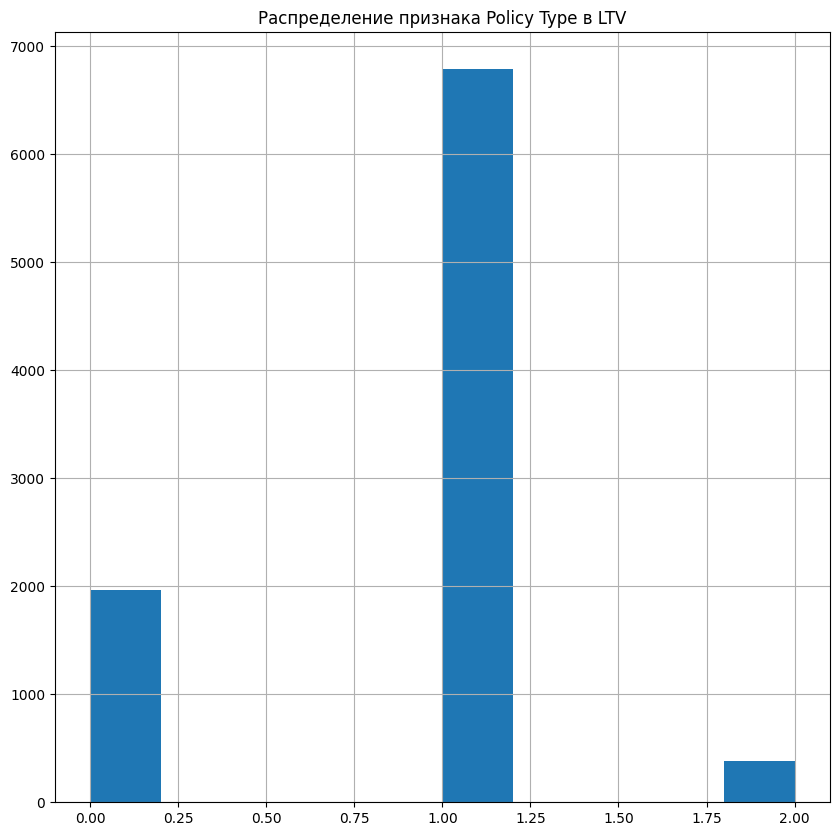

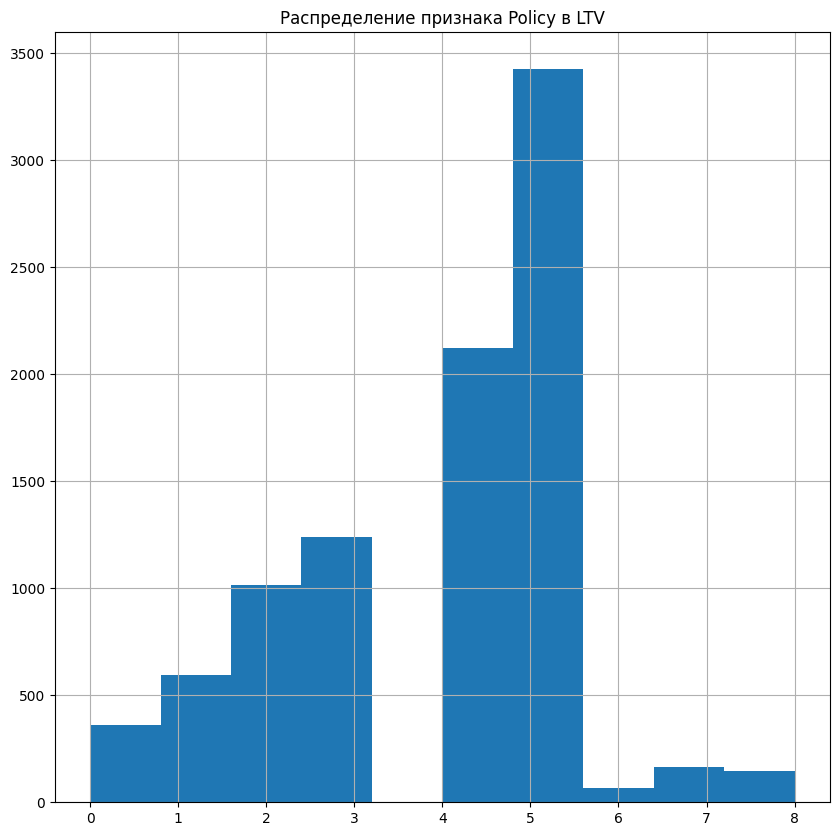

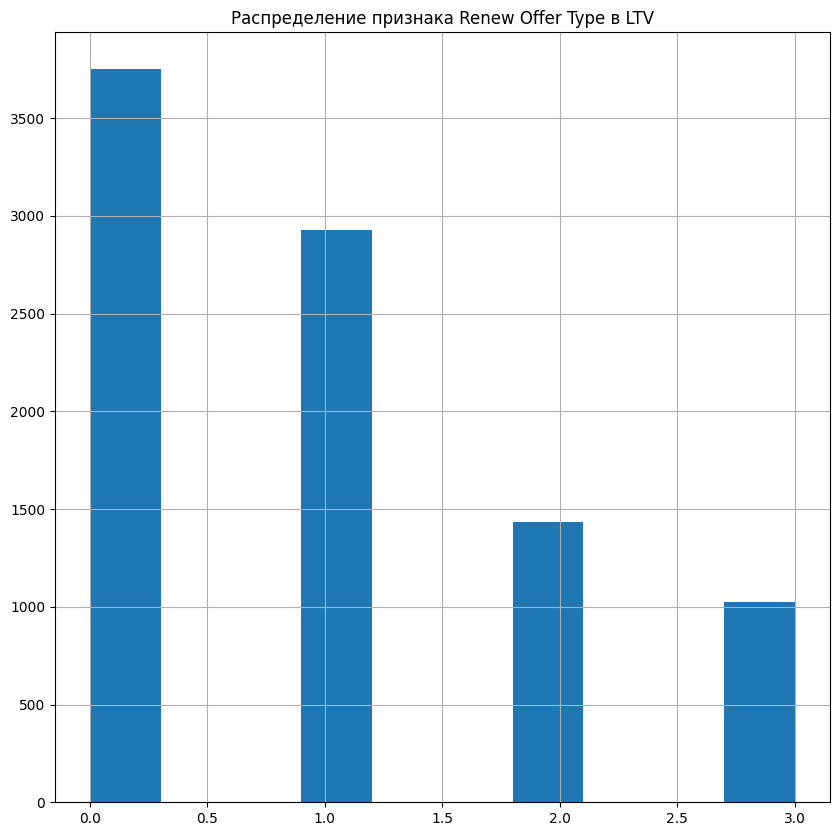

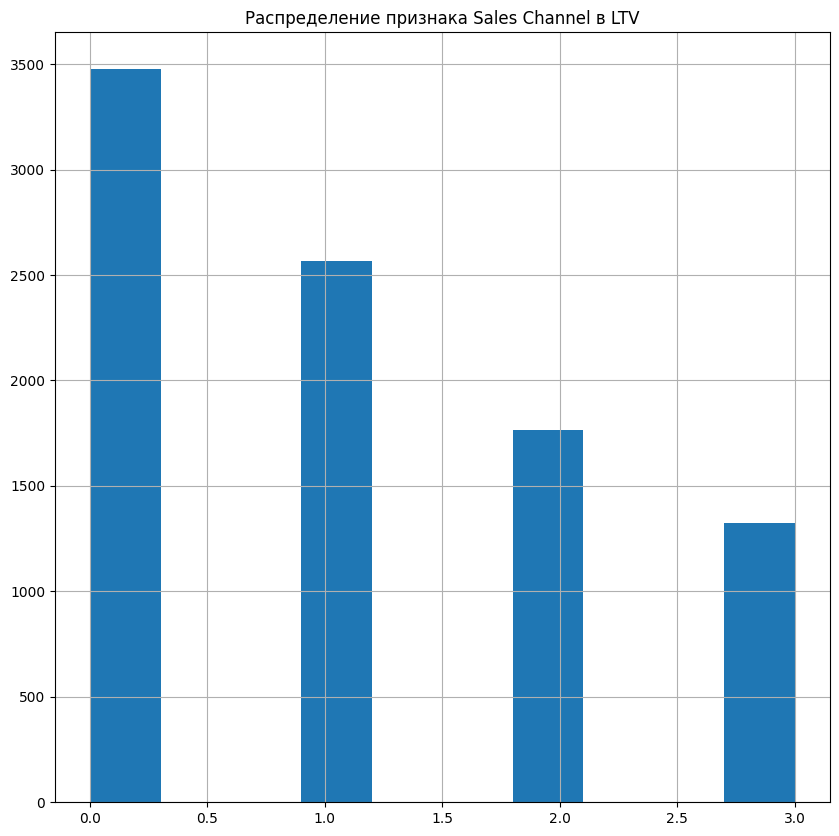

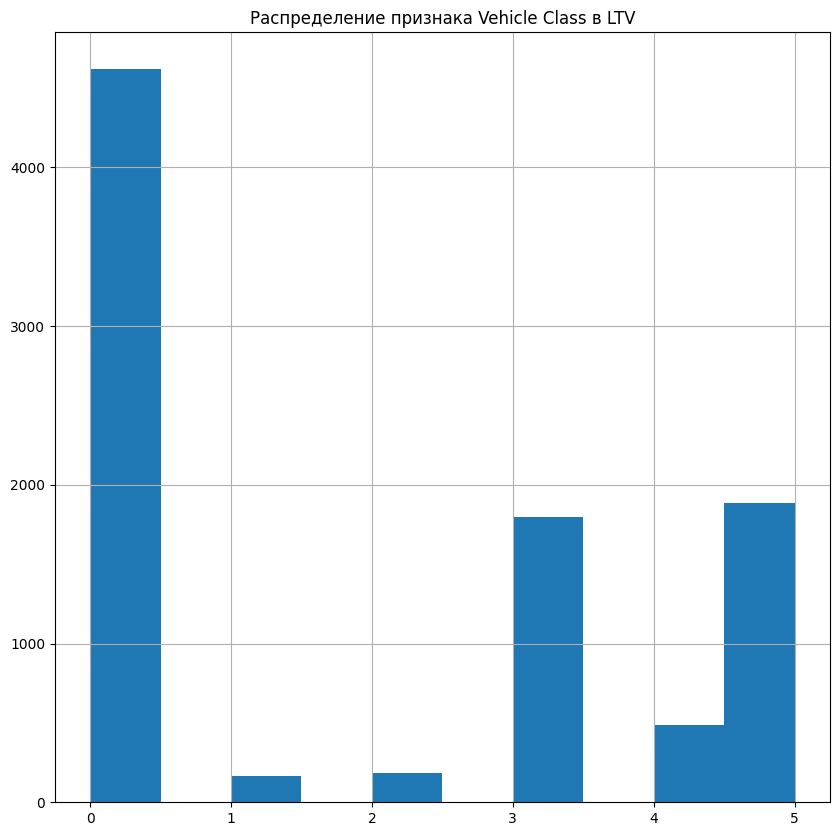

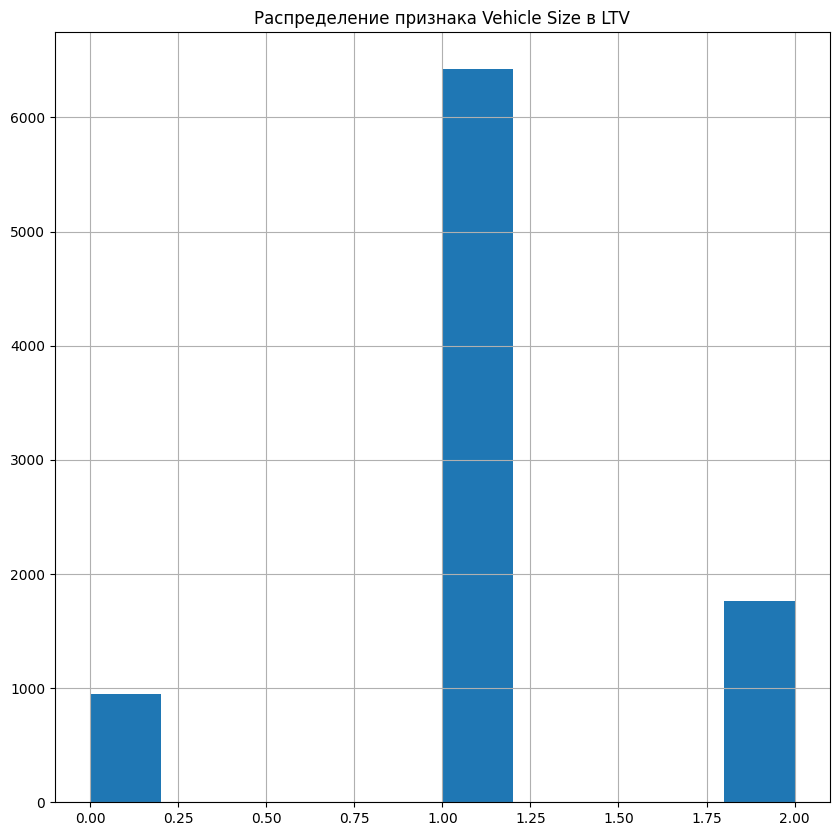

In [58]:
for col in str_cols:
    plt.figure(figsize = (10, 10))
    plt.title(f'Распределение признака {col} в LTV')
    df[col].hist()

In [16]:
train_df.sample(5)

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Customer,State,...,EmploymentStatus,Gender,Location Code,Marital Status,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size
1750,2859.528930,99981,71,2,22,0,1,204.872273,797,1,...,1,1,2,1,2,7,1,3,0,2
6471,8044.872393,71391,67,29,39,0,2,284.000172,5237,3,...,1,1,2,1,1,5,1,0,0,1
7810,33473.349460,33190,106,18,95,0,2,508.800000,4620,2,...,1,0,1,0,1,5,0,3,3,1
6598,8083.917906,31506,102,23,50,0,8,601.074585,5604,1,...,1,0,1,1,1,3,0,3,0,2
1365,5391.078171,21440,135,7,19,0,1,972.000000,4765,4,...,1,1,1,1,1,5,2,0,3,1


In [17]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_sc = sc.fit_transform(X)

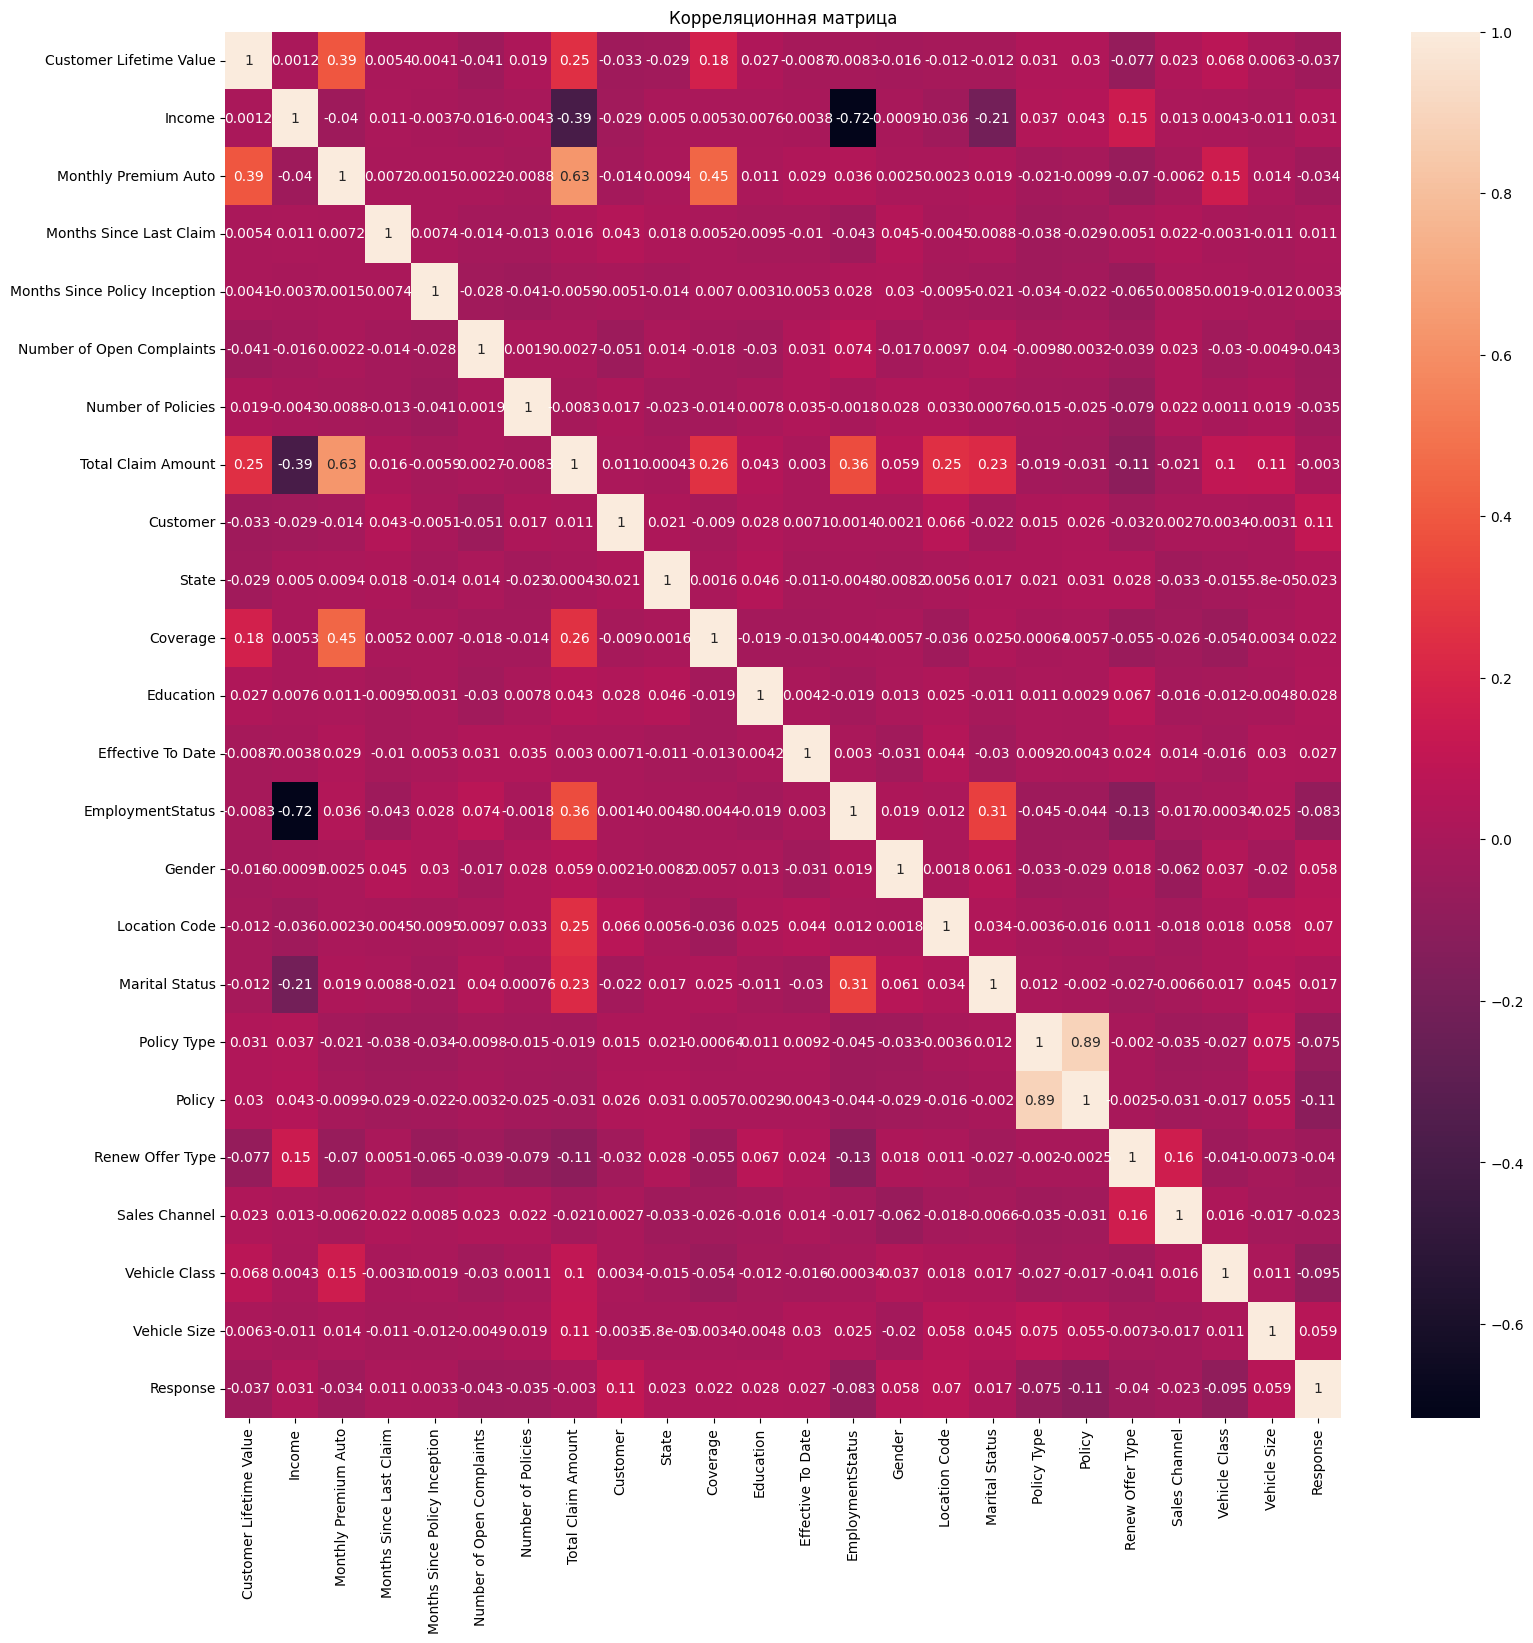

In [18]:
# Преобразуем матрицу признаков в DataFrame
train_data_trasformed = pd.DataFrame(X_sc, columns = X.columns)
train_data_trasformed['Response'] = y
# Создаем корреляционную матрицу
corr_m = train_data_trasformed.corr()



# Визуализируем матрицу при помощи sns.heatmap-тепловая карта
plt.figure(figsize = (18, 18))
plt.title('Корреляционная матрица')
sns.heatmap(corr_m, annot = True)
plt.show()

в линейной регрессии избегаем мультикореляционных признаков потому как плохо влияют на обучение модели(единицы присоединившиеся к главной диогонали едениц)

наглядно видем по матрице это параметр Страховка и тип Страховки. Либо удаляем один из призников либо обьеденяем два параметра в один новый. мной было принято решение удалить мене информативный параметр Страховка

In [19]:
train_df = train_df.drop(columns=['Policy'])

Помним что изменения в train датасете. требует аналогичных изменений в test

In [20]:
test_df = test_df.drop(columns=['Policy'])

In [54]:
# Логистическая регрессия
from sklearn.linear_model import LogisticRegression

# Кросс-валидация
from sklearn.model_selection import cross_validate

log_reg = LogisticRegression(C = 0.8, random_state = 42, max_iter = 500)

cv_log_reg = cross_validate(log_reg, X_sc, y, cv = 15, scoring = 'accuracy')

print("Результаты Логистической регрессии:", sum(cv_log_reg['test_score']) / len(cv_log_reg['test_score']))

Результаты Логистической регрессии: 0.857616402474823


In [56]:
# Решающее дерево
from sklearn.tree import DecisionTreeClassifier


dec_tree = DecisionTreeClassifier(random_state = 62)

cv_dec_tree = cross_validate(dec_tree, X_sc, y, cv = 15, scoring = 'accuracy')

print("Результаты решающего дерева:", sum(cv_dec_tree['test_score']) / len(cv_dec_tree['test_score']))

Результаты решающего дерева: 0.8697195501964505


In [53]:
# Случайный лес
from sklearn.ensemble import RandomForestClassifier


ran_for = RandomForestClassifier(random_state = 84)

cv_ran_for = cross_validate(ran_for, X_sc, y, cv = 15, scoring = 'accuracy')

print("Результаты решающего дерева:", sum(cv_ran_for['test_score']) / len(cv_ran_for['test_score']))

Результаты решающего дерева: 0.9309985096870342


In [44]:
log_reg.fit(X, y)
print("Коэффициенты в линейной регрессии:", log_reg.coef_)

Коэффициенты в линейной регрессии: [[-1.21635552e-05 -1.09510350e-06 -1.60117272e-03 -2.39389924e-02
   3.16804030e-03 -8.46671931e-03 -7.91701470e-02 -1.54262421e-04
   2.02934224e-05 -6.54405739e-02  1.18048577e-02 -2.39430800e-02
  -1.34890267e-02 -7.25832440e-02 -1.22677403e-02 -1.57617400e-02
  -7.80062110e-02 -1.04693577e-02 -3.82486399e-02 -1.30328666e-01
  -1.02900416e-01  4.21006649e-02 -4.90562095e-02]]


In [45]:
dec_tree.fit(X, y)
print("Важность признаков решающего дерева", dec_tree.feature_importances_)

Важность признаков решающего дерева [0.10720991 0.09169673 0.04970347 0.05400351 0.10376788 0.00843931
 0.02302863 0.04519033 0.0534118  0.00606542 0.00459269 0.03335377
 0.12239378 0.05175178 0.         0.01108806 0.04306138 0.00300915
 0.0219238  0.08531836 0.05293221 0.00784501 0.02021303]


In [46]:
!pip install shap

In [47]:
import shap
# Загружаем JS шаблоны для визуализации
shap.initjs()

# Обязателен явный вызов метода fit
ran_for.fit(X, y)

print("Обучили модель, переходим к визуализации")
# Интерпретируем предсказания модели при помощи SHAP
explainer = shap.TreeExplainer(ran_for)
shap_values = explainer.shap_values(X)

Обучили модель, переходим к визуализации


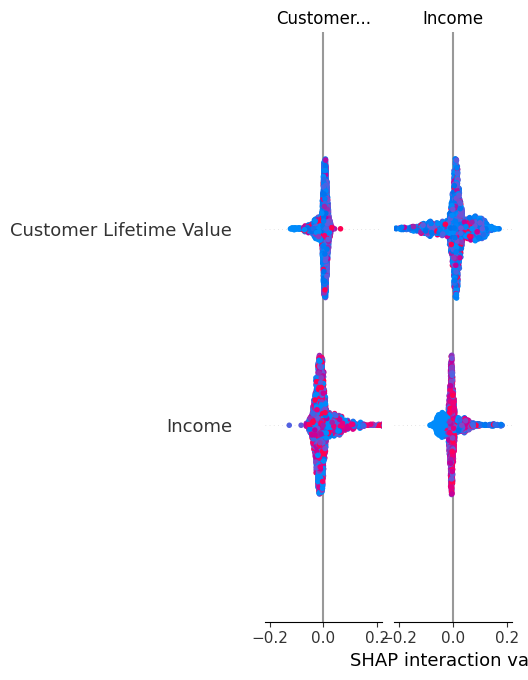

In [28]:
# Общий график
shap.summary_plot(shap_values, X, plot_type="bar")